# Esercitazione 1 - Laboratorio di Simulazione Numerica
### Matteo Robbiati

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc

In [9]:
sns.set_theme(font_scale=1.7, style='whitegrid') 

### Caricamento dei risultati

In [10]:
uniform = np.loadtxt("Results/results.dat")
chiquad = np.loadtxt("Results/chiquad.dat")
chi = np.loadtxt("Results/chiquad_block.dat")
TLC_uni = np.loadtxt("Results/TLC_uniform.dat")
TLC_exp = np.loadtxt("Results/TLC_exponential.dat")
TLC_cau = np.loadtxt("Results/TLC_cauchy.dat")
buffon = np.loadtxt("Results/buffon.dat")

### Esercizio uno
#### Parte uno

In questo primo esercizio abbiamo valutato il valore atteso e la varianza di una variabile $r$, generata a partire dal metodo `Rannyu()` del codice proposto come LCG. La nostra intenzione è quella di verificare se i momenti della distribuzione, che sono soluzione degli integrali:

$$ \langle r\rangle = \int_0^1 r \, \mathrm{d}r, \qquad \qquad \langle(r-0.5)^2\rangle = \int_0^1 (r-0.5)^2 \mathrm{d}r, $$

sono compatibili con la teoria; un buon generatore di numeri casuali secondo la distribuzione uniforme in $[0,1)$ deve avere media 1/2 e varianza 1/12. Volendo stimare i valori degli integrali e le rispettive incertezze, abbiamo approfondito un metodo che ne permette il calcolo, che ho implementato nel mio codice come metodo `blocking` della classe `Statistic`. L'idea consiste nello svolgere una media iterativa su $N$ misure di una variabile, ciascuna delle quali è ottenuta come media di $M/N=L$ realizzazioni. In pratica effettuiamo $M=10^4$ ma da queste ricaviamo $N=10^2$ misure. Proprio per questo, il metodo `blocking` sfrutta al suo interno, la funzione `block_step`, tramite cui genero le singole misure come medie di $L$ realizzazioni.

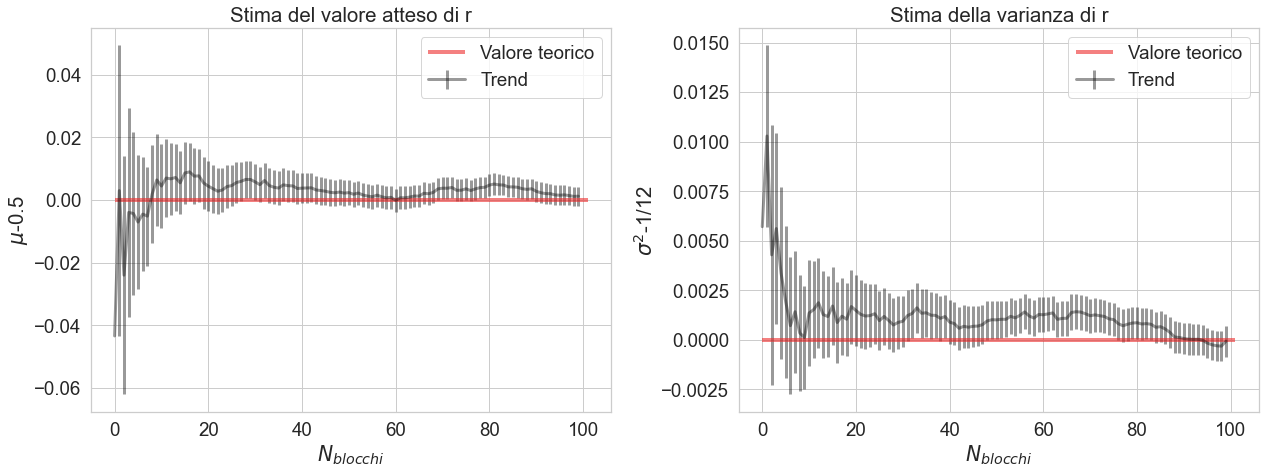

In [11]:
x = np.arange(100)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
plt.title("Stima del valore atteso di r")
plt.errorbar(x, uniform.T[0]-0.5, yerr=uniform.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-0.5")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("Stima della varianza di r")
plt.errorbar(x, uniform.T[2]-1/12, yerr=uniform.T[3], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\sigma^2$-1/12")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()

plt.show()

**Figura 1:** a sinistra, stima del valore atteso di $r$ in funzione del numero di blocchi, a destra stima della varianza di $r$ in funzione del numero di blocchi. In entrambi i casi l'incertezza, rappresentata in barra d'errore, denota compatibilità con il valore teorico, rappresentato in rosso (la linea è collocata sullo zero perché, per comodità, abbiamo traslato dei valori teorici attesi i due risultati).

#### parte due

Per verificare in modo più accurato la bontà del nostro generatore di numeri casuali abbiamo calcolato un $\chi^2$ associato al processo. Più precisamente, ho analizzato la distribuzione di 100 variabili  $\chi^2$, ognuna delle quali valutata su sulla distribuzione di $M=10^4$ variabili $r_i$ in $n=100$ intervalli uguali in cui ho diviso $[0,1)$. Per svolgere questo controllo ho sfruttato il metodo `Rannyu` fornito dalla classe `Random` per generare numeri nell'intervallo $[0,1)$. Ho successivamente moltiplicato ciascun valore $r_i$ per 100 e ne ho preso la parte intera $\lfloor r_i \rfloor$. Ho dunque aumentato di 1 il valore di un `vector` di contatori nella posizione corrispondente all'indice $\lfloor r_i \rfloor$. Una volta accumulate le variabili contatore, che chiamo $n_i$, con $i=1,...,100$, ho calcolato i chi quadro come segue:

$$ \chi^2 = \sum_{i=1}^{100} \frac{(n_i-\langle n_i \rangle)^2}{\langle n_i \rangle}. $$ 

Questa scelta è un'approssimazione motivata dal fatto che, per $ n \ll M $ si ha che $\sigma_i^2\approx n/M \equiv \langle n_i \rangle$.
Ho svolto per cento volte questa operazione e il risultato sono altrettanti valori di $\chi^2$ rappresentati nel grafico seguente.

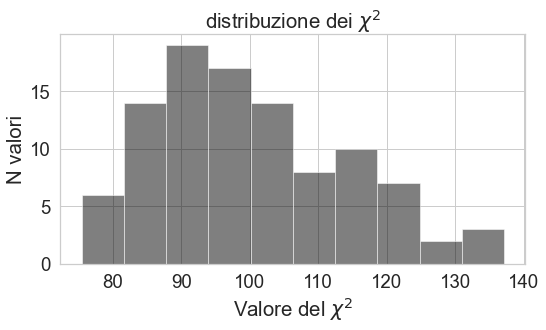

In [12]:
plt.figure(figsize=(8,5))

plt.title("distribuzione dei $\chi^2$")
plt.hist(chiquad, bins=10, color='black', alpha=0.5)
plt.xlabel('Valore del $\chi^2$')
plt.ylabel('N valori')

plt.tight_layout()

plt.show()

**Figura 2:** istogramma che rappresenta la distribuzione dei valori di $\chi^2$ ottenuti ripetendo cento volte il calcolo. La distribuzione non è regolare e, certamente, non sembra avere un picco centrato in $100$, che è il valore teorico che ci attendiamo per $\chi^2$. 

### Esercizio due

In questo secondo esercizio vogliamo controllare la validità del teorema del limite centrale (TLC). 
Esso afferma che, definita una variabile $S_N = \frac{1}{N}\sum_i x_i$, con $x_i$ variabili estratte da distribuzioni qualsiasi, tali che la varianza sia finita, la distribuzione di $S_N$ tende ad una gaussiana al tendere di $N$ a infinito. La condizione sui momenti centrali di ordine due che devono soddisfare le variabili è cruciale: se consideriamo variabili la cui varianza diverge (ad esempio variabili estratte da una distribuzione di Cauchy), vedremo che la distribuzione degli $S_N$ tende ad altre distribuzioni (altri attrattori).
Per evidenziare questi due aspetti abbiamo svolto le seguenti operazioni:
- campionato $N=10^4$ variabili $S_N$, ottenute tramite media aritmetica di $N=\{1,2,10,100\}$ variabili $x_i$; 
- svolto questa operazione considerando diverse distribuzioni per $x_i$: uniforme in $[0,1)$, esponenziale con $\lambda=1$ e cauchy con $\mu=0, \Gamma=1$.

Questo ci permette di evidenziare il bacino di attrazione della distribuzione gaussiana e il fatto che la distribuzione di Cauchy non ne fa parte, tendendo invece alla stessa distribuzione di Cauchy.

Per svolgere il campionamento delle variabili $x_i$ a partire dalle p.d.f. citate abbiamo implementato il metodo dell'inversione, partendo da $r_i$ generate da $\mathcal{U}[0,1)$ e sfruttando l'equivalenza delle c.d.f.

#### Fit gaussiani e cauchy per le distribuzioni ottenute

In [13]:
fit_uni = sc.norm.fit(TLC_uni.T[3])
fit_exp = sc.norm.fit(TLC_exp.T[3])
fit_cau = sc.cauchy.fit(TLC_cau.T[3])

y = np.linspace(-10, 10, 10000)

pdf_uni = sc.norm.pdf(y, fit_uni[0], fit_uni[1])
pdf_exp = sc.norm.pdf(y, fit_exp[0], fit_exp[1])
pdf_cau = sc.cauchy.pdf(y, fit_cau[0], fit_cau[1])

#### Distribuzione delle variabili $S_N$

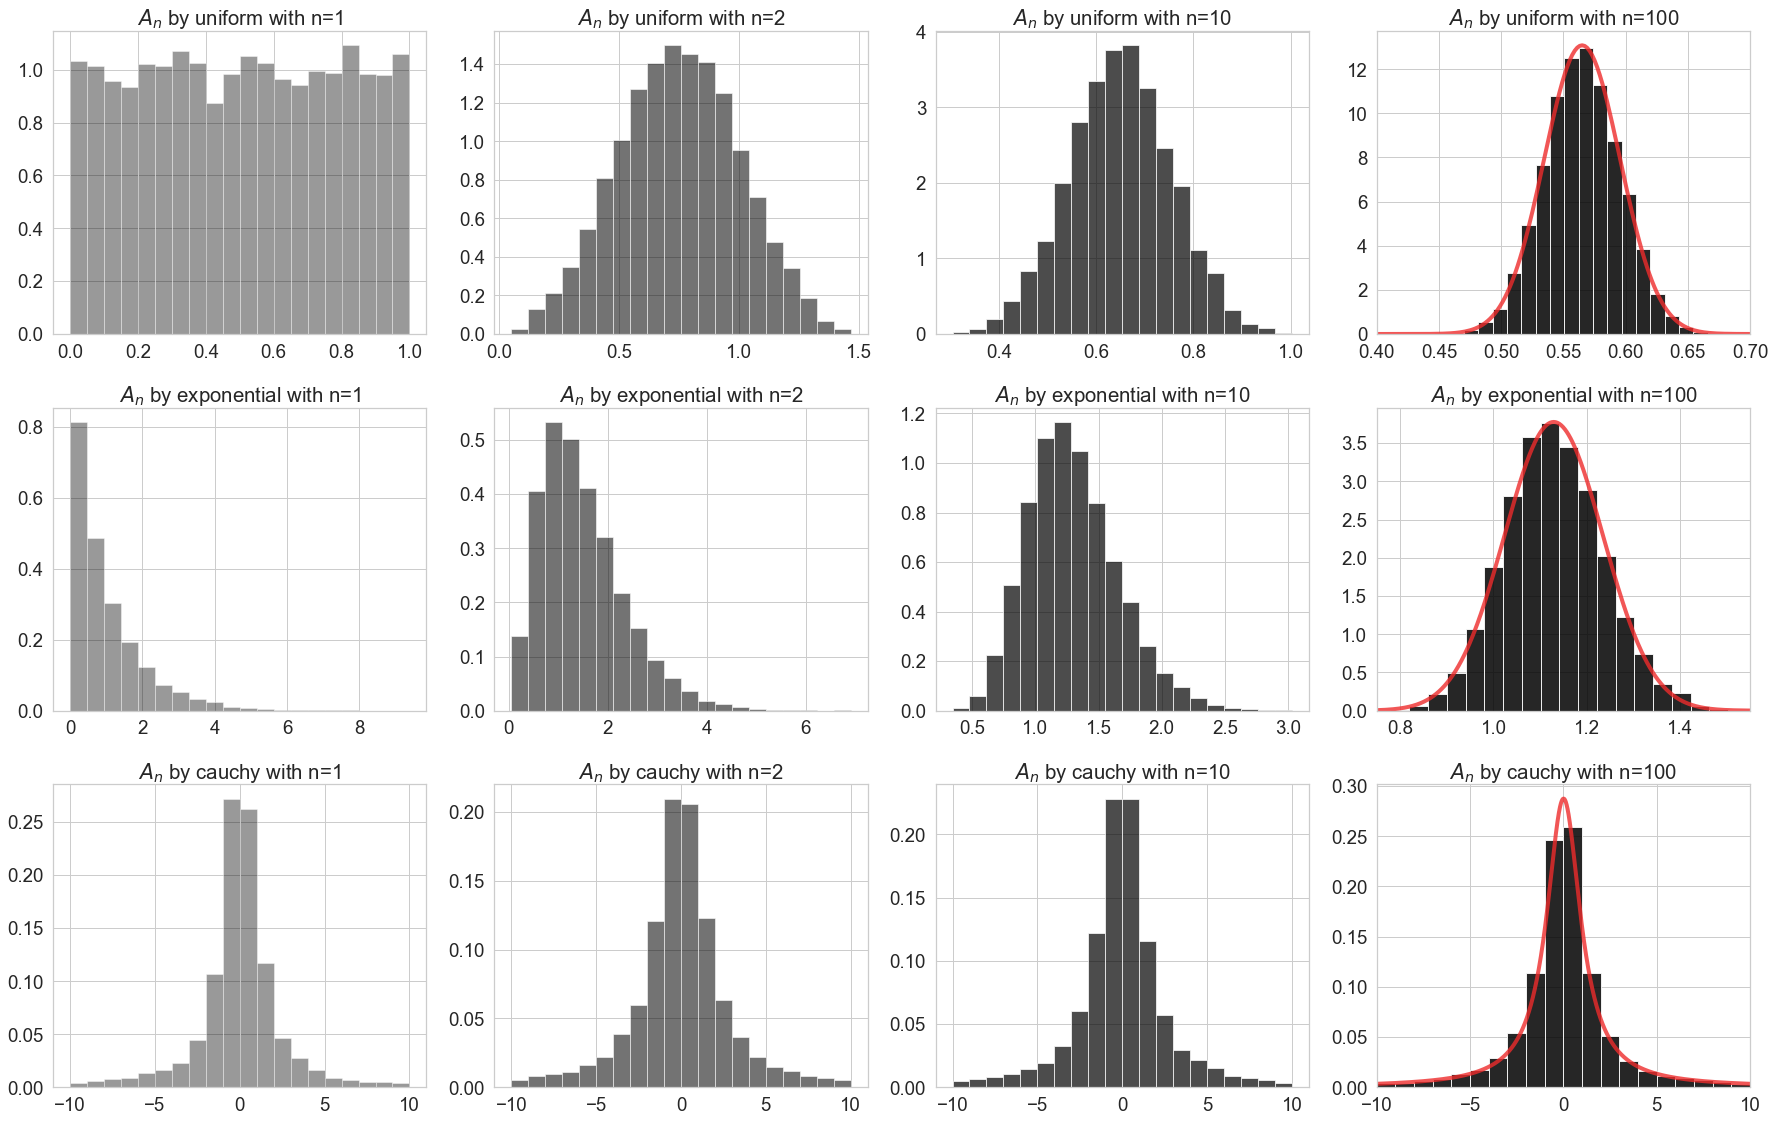

In [25]:
N = [1,2,10,100]

plt.figure(figsize=(25,16))
for i in range(12):
    plt.subplot(3,4,i+1)
    if(i<4):
        plt.title('$A_n$ by uniform with n='+str(N[i]))
        plt.hist(TLC_uni.T[i], bins=20, color='black', alpha=0.4+i*0.15, density=True)
        if(i==3):
            plt.plot(y, pdf_uni, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(0.4,0.7)
    elif(i<8):
        plt.title('$A_n$ by exponential with n='+str(N[i-4]))
        plt.hist(TLC_exp.T[i-4], bins=20, color='black', alpha=0.4+(i-4)*0.15, density=True)
        if(i==7):
            plt.plot(y, pdf_exp, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(0.75,1.55)
    elif(i<12):
        plt.title('$A_n$ by cauchy with n='+str(N[i-8]))
        plt.hist(TLC_cau.T[i-8], bins=20, color='black', alpha=0.4+(i-8)*0.15, range=(-10,10), density=True)
        if(i==11):
            plt.plot(y, pdf_cau, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(-10,10)
plt.tight_layout()
plt.savefig('TLC.png')
plt.show()    

**Figura 3:** nella prima riga, da sinistr verso destra istogrammi che rappresentano le distribuzioni della variabile $S_N$ ottenuta come media aritmetica di $N=\{1,2,10,100\}$ variabili estratte da p.d.f. uniforme. La quarta figura presenta anche il fit effettuato con distribuzione gaussiana. Le successive due righe rappresentano la stessa configurazione, considerando, dall'alto verso il basso, sovrapposizione di variabili estratte da p.d.f. esponenziale e cauchy.

### Esercizio tre

In questo terzo esercizio abbiamo implementato l'esperimento di Buffon per stimare il valore di $\pi$. Egli dedusse che, disegnando su un piano un fascio di rette parallele e distanziate l'una dall'altra da una distanza $d$, il numero di volte $N_{colpi}$ che un ago di lunghezza $L$ e lanciato casualmente sul piano intersecava le rette poteva essere utilizzato nella stima di $\pi$; infatti, si può dimostrare che la probabilità che l'ago tocchi una delle righe è $P=2L/\pi d$, da cui:

$$ \pi = \frac{2L}{Pd} = \lim_{N_{lanci}\to\infty} \frac{2L N_{lanci}}{N_{colpi}d}.$$

L'idea consiste nel generare un valore  $y_1$ che coincide all'odrinata di una delle estremità del mio ago. Genero questo valore all'interno di un range $[0,d)$. A questo punto ho bisogno di generare in modo uniforme il seno di un angolo, così da moltiplicarlo per $L$ e ottenere il valore di $y_2$, cioè la seconda estremità dell'ago. Se questa assume un valore superiore a $d$ o inferiore a $0$ aggiungo un colpo al mio conteggio.
Per implementare la generazione del seno ho scritto un metodo, `generate_sin_angle`, che ho aggiunto alla classe `Random` e in cui genero coppie di punti (x,y) nel semipiano che contiene la semicirconferenza positiva di raggio uno. Così facendo posso valutare il seno.

Nella simulazione ho utilizzato il metodo `blocking` introdotto in precedenza. Le misure di $\pi$ sono ricavate esplicitamente nel metodo `block_step` e valutate come media secondo la stessa procedura esposta nel paragrafo relativo all'esercizio uno. 

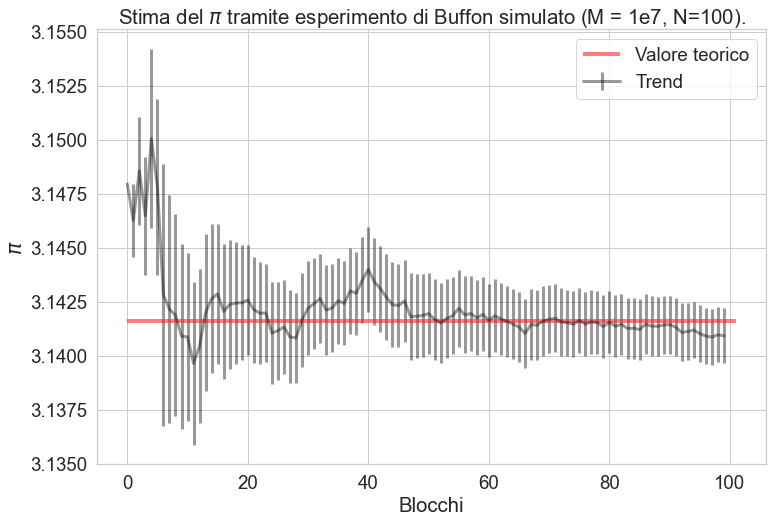

In [16]:
x = np.arange(100)

plt.figure(figsize=(12,8))

plt.title("Stima del $\pi$ tramite esperimento di Buffon simulato (M = 1e7, N=100).")
plt.errorbar(x, buffon.T[0], yerr=buffon.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(np.pi,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\pi$")
plt.xlabel("Blocchi")
plt.legend()
plt.show()

**Figura 4:** stima del valore atteso di $\pi$ in funzione del numero di blocchi.